In [2]:
import numpy as np
import os
import math
from matplotlib import pyplot as plt
import torch
import os

from torch.utils.tensorboard import SummaryWriter
from tqdm import trange

from scipy.linalg import inv, cho_factor, cho_solve
import glob
import optuna

torch.manual_seed(1)
from Kalman_module_trial import *
from augment import *
from normalize import Normalization
from model import lstm_encoder, lstm_decoder, lstm_seq2seq, EnsembleModel, xavier_initialize, he_initialize
from utils import *
from dataset import TrajDataset
import pickle as pkl

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

/home/anshul/miniconda3/envs/uncertainty_aware/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3060 Laptop GPU'

In [3]:

def read_file(_path, delim='\t'):
    data = []
    if delim == 'tab':
        delim = '\t'
    elif delim == 'space':
        delim = ' '
    with open(_path, 'r') as f:
        for line in f:
            line = line.strip().split(delim)
            line = [float(i) for i in line]
            data.append(line)
    return np.asarray(data)

def poly_fit(traj, traj_len, threshold):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[0, -traj_len:], 2, full=True)[1]
    res_y = np.polyfit(t, traj[1, -traj_len:], 2, full=True)[1]
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0

data_dir = "/home/anshul/Research/Pred_unc_aware_planning/Pedestrian_Trajectory_Prediction/scripts/datasets/eth/train"
delim = "\t"
skip = 2
obs_len = 8
pred_len = 12


def dataset(data_dir, delim = '\t', skip = 1, obs_len = 8, pred_len =12, origin = 'last_obs'):

    seq_len= obs_len + pred_len
    all_files = os.listdir(data_dir)
    all_files = [os.path.join(data_dir, _path) for _path in all_files]
    num_peds_in_seq = []
    seq_list = []
    initial_pos = []
    seq_list_rel = []
    loss_mask_list = []
    non_linear_ped = []
    for path in all_files:
        data = read_file(path, delim) 
        frames = np.unique(data[:, 0]).tolist() # Frames Refer to the 2.5 HZ (0.4 sec) capture 
        frame_data = []
        for frame in frames:
            frame_data.append(data[frame == data[:, 0], :])
        num_sequences = int(math.ceil((len(frames) - seq_len + 1) / skip))


        for idx in range(0, num_sequences * skip + 1, skip):
                    curr_seq_data = np.concatenate(
                        frame_data[idx:idx + seq_len], axis=0)
                    peds_in_curr_seq = np.unique(curr_seq_data[:, 1])


                    curr_seq_rel = np.zeros((len(peds_in_curr_seq), 2,
                                            seq_len))
                    curr_seq = np.zeros((len(peds_in_curr_seq), 2, seq_len))
                    curr_loss_mask = np.zeros((len(peds_in_curr_seq),
                                            seq_len))
                    num_peds_considered = 0
                    non_linear_ped = []
                    for _, ped_id in enumerate(peds_in_curr_seq):
                        curr_ped_seq = curr_seq_data[curr_seq_data[:, 1] ==
                                                    ped_id, :]
                    
        
                        curr_ped_seq = np.around(curr_ped_seq, decimals=4)
                        pad_front = frames.index(curr_ped_seq[0, 0]) - idx
                        pad_end = frames.index(curr_ped_seq[-1, 0]) - idx + 1
                        if pad_end - pad_front != seq_len:
                            continue
                        curr_ped_seq = np.transpose(curr_ped_seq[:, 2:]) # stores the (x,y)  coordinates for each pedestrian
                        
                        
                        
                        if origin == 'first_obs':
                             starting_pos  =  curr_ped_seq[:,0][:, np.newaxis].copy()
                             curr_ped_seq -=  curr_ped_seq[:,0][:, np.newaxis]
                           
                             
                             
                             
                        elif origin =='last_obs':
                             starting_pos  = curr_ped_seq[:,obs_len-1][:,np.newaxis].copy()
                             curr_ped_seq -= curr_ped_seq[:,obs_len-1][:,np.newaxis]
                             
                             
                             
                        elif origin =='original':
                             starting_pos  = np.zeros(2,).copy()
                             curr_ped_seq  = curr_ped_seq


                        # Append Homoskedastic Noise as state Uncertainty:
                        sigma = 0.005
                        noise = np.random.rand(2, seq_len) * sigma **2
                        curr_ped_seq = np.concatenate((curr_ped_seq, noise), axis = 0)

                        seq_list.append(curr_ped_seq)
                        initial_pos.append(starting_pos)
                       

    initial_pos = np.array(initial_pos)
    seq_list = np.array(seq_list)
    seq_list = seq_list.transpose(0,2,1)
    seq_list = np.expand_dims(seq_list, axis =1)
    initial_pos = np.array(initial_pos)
    return seq_list, initial_pos


# loss_mask_list = np.concatenate(loss_mask_list, axis=0)
# non_linear_ped = np.asarray(non_linear_ped)


In [4]:

train_dir = "/home/anshul/Research/Pred_unc_aware_planning/Pedestrian_Trajectory_Prediction/scripts/datasets/zara2/train"
val_dir = "/home/anshul/Research/Pred_unc_aware_planning/Pedestrian_Trajectory_Prediction/scripts/datasets/zara2/val"
test_dir = "/home/anshul/Research/Pred_unc_aware_planning/Pedestrian_Trajectory_Prediction/scripts/datasets/zara2/test"

train_data, train_start_pos = dataset(train_dir, delim = '\t', skip = 1, obs_len = 8,  pred_len =12, origin = 'original' )
val_data, val_start_pos = dataset(val_dir, delim = '\t', skip = 1, obs_len = 8,  pred_len =12, origin = 'original' )
test_data, test_start_pos = dataset(test_dir, delim = '\t', skip = 1, obs_len = 8,  pred_len =12, origin = 'original' )

In [5]:
test_data.shape

(5910, 1, 20, 4)

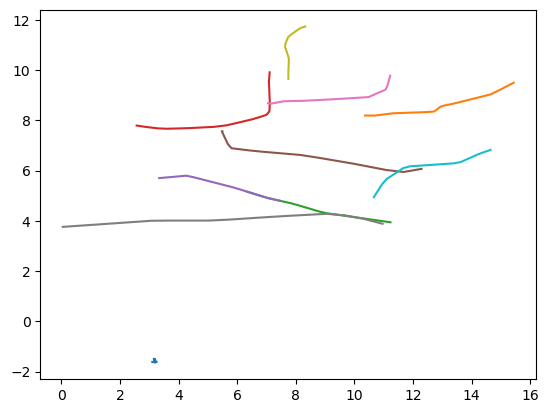

In [6]:
indices = np.random.randint(train_data.shape[0], size =10)
for idx in indices:
    plt.plot(train_data[idx, 0, :, 0], train_data[idx, 0, :, 1])

In [25]:
# Loading the data on the device
num_fea = 2

def normalize_data(data):
    reshaped_data = data.reshape(-1, data.shape[-1])
    
    mean = torch.mean(reshaped_data, dim = 0)
    std = torch.std(reshaped_data, dim = 0)
    
    normalized_data = (data - mean)/std
    return normalized_data, mean, std

def denormalize_data(data, mean, std):
    denormalized_data = (data * std) + mean
    return denormalized_data

def generate_dataloader(gaussian_traj, num_fea, normalize = True):
    gaussian_traj = torch.tensor(gaussian_traj).float().to(device)
    if normalize:
        gaussian_traj, mean, std = normalize_data(gaussian_traj)
        input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
        return gaussian_traj, input_traj, output_traj, mean, std
    else:
        mean, std  = None, None
        input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
        return gaussian_traj, input_traj, output_traj
    
    
gaussian_train_traj, train_input, train_output = generate_dataloader(train_data, num_fea, normalize = False)
gaussian_val_traj, val_input, val_output = generate_dataloader(val_data, num_fea, normalize = False)
gaussian_test_traj, test_input, test_output = generate_dataloader(test_data, num_fea, normalize = False)



Initializing module: lstm_seq2seq(
  (encoder): lstm_encoder(
    (dropout): Dropout(p=0.25, inplace=False)
    (lstm): LSTM(4, 128, num_layers=2, dropout=0.25)
  )
  (decoder): DecoderAttention(
    (dropout): Dropout(p=0.25, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=256, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (lstm): LSTM(132, 128, num_layers=2)
    (linear): Linear(in_features=256, out_features=6, bias=True)
  )
)
Initializing module: lstm_encoder(
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(4, 128, num_layers=2, dropout=0.25)
)
Initializing module: Dropout(p=0.25, inplace=False)
Initializing module: LSTM(4, 128, num_layers=2, dropout=0.25)
Initializing LSTM param: weight_ih_l0
Initializing LSTM param: weight_hh_l0
Initializing LSTM param: bias_ih_l0
Initializing LSTM param: bias_hh_l0
Initializing LSTM param: weight_ih_l1
Initializing LSTM param: weight_hh_l1
Initializing

 50%|█████     | 50/100 [04:12<04:12,  5.06s/it, loss=-0.253, val_loss=-0.197]

Early stopping triggered
Model No.1 trained.
-0.19734169745734378


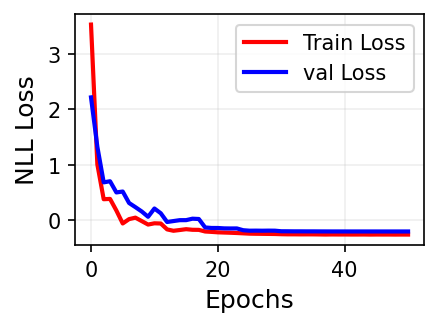

Train MSE: 0.16040241718292236
Test MSE: 0.10601955652236938


In [26]:
# Create the tensor dataset
from torch.utils import tensorboard
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
import random

# Define the full path to your log directory
log_dir = r"/home/anshul/OneDrive/Pred_unc_aware_planning/Deep_Ensemble/runs/Attention"

# Ensure the directory exists
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)


# idx = list(range(num_traj))
# random.shuffle(idx)


batch_size = 64
hidden_size = 128
dropout = 0.25
beta = 0.2
teacher_forcing_ratio = 0.76
learning_rate = 0.0044
num_layers = 2
num_models = 1
dynamic_TF = True
optimizer_name = 'Adam'
num_fea = train_input.shape[3]
preds, sigmas = [],[]
losses = []
train_MSE, test_MSE = [], []
min_val = -1
max_val = 1

# def objective(trial):

#     # Log trial information
#     print(f"Starting trial {trial.number} with parameters: {trial.params}")


# Define search space:
'''
optuna results:
Best trial:
'learning_rate': 0.004462667760163701,
'beta': 0.2,
'teacher_forcing_ratio': 0.7652066111782738,
'batch_size': 64,
'optimizer_name': 'Adam',
'hidden_size': 128,
'dynamic_tf': 'True',
'dropout': 0.2532220879893445


{'learning_rate': 0.00803494629958372, 
'teacher_forcing_ratio': 0.8818260080309833,
'batch_size': 32, 
'optimizer_name': 'Adam', 
'hidden_size': 64, 
'init_weight': 'xavier_initialize',
'dynamic_tf': 'True',
'dropout': 0.30287832302041306}

'''
# learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2) 
# beta = trial.suggest_categorical('beta', [0.1, 0.2, 0.3, 0.4, 0.5])
# teacher_forcing_ratio = trial.suggest_float('teacher_forcing_ratio', 0.0, 1.0)
# batch_size = trial.suggest_categorical('batch_size',[32, 64,128,256])
# optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','SGD','RMSProp'])
# hidden_size = trial.suggest_categorical('hidden_size',[64, 128, 256])
# # init_weight = trial.suggest_categorical('init_weight',['xavier_initialize','he_initialize'])
# dynamic_TF = trial.suggest_categorical('dynamic_tf',['True','False'])
# dropout = trial.suggest_float('dropout', 0, 0.5)

# hidden_size = np.random.choice([64,128,256])
deep_ensemble = EnsembleModel(input_size = num_fea, hidden_size = hidden_size, output_size = num_fea + 2, num_layers = num_layers, 
                                dropout = dropout,  use_attention= True, device = device, num_models = num_models, init_weight = xavier_initialize)

ensemble_val_loss = []
for i, model  in enumerate(deep_ensemble.models):

#     print(i)
#     train_data = TrajDataset(train_input[:,i,:,:], train_output[:,i,:,:], min_val = min_val, max_val = max_val)
#     val_data =  TrajDataset(val_input[:,i,:,:], val_output[:,i,:,:], min_val = min_val, max_val = max_val)
#     test_data = TrajDataset(test_input[:,i,:,:], test_output[:,i,:,:], min_val = min_val, max_val = max_val)

    train_data = TensorDataset(train_input[:,i,:,:], train_output[:,i,:,:])
    val_data =  TensorDataset(val_input[:,i,:,:], val_output[:,i,:,:])
    test_data = TensorDataset(test_input[:,i,:,:], test_output[:,i,:,:])

    # Train, validataion and Test DataLoader
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)
    val_loader =   DataLoader(val_data, batch_size = batch_size, shuffle = False)
    test_loader =  DataLoader(test_data, batch_size = batch_size, shuffle = False)
    
#     train_features, train_labels = next(iter(train_loader))
#     print('Train Features :',train_features)
#     print('Train labels :',train_labels)

# Load the model
#     model = lstm_seq2seq(input_size = num_fea ,hidden_size = 128, device = device)
#     print(model)

#     break

    loss, val_loss = model.train_model(device,
                            train_loader, 
                            val_loader,
                            n_epochs = 100, 
                            target_len = pred_len, 
                            beta = beta,
                            training_prediction ='teacher_forcing', 
                            teacher_forcing_ratio = teacher_forcing_ratio, 
                            learning_rate = learning_rate,  
                            dynamic_tf = dynamic_TF,
                            optimizer_name = optimizer_name,
                            writer = writer
                            )
    
    # for n_iter in range(loss.shape):
    #     writer.add_scalar('Training Loss', loss[n_iter], n_iter)
    #     writer.add_scalar('validation Loss', val_loss[n_iter], n_iter)
        
    print('Model No.{} trained.'.format(i+1))
    valid_val_losses = [loss for loss in val_loss if not np.isnan(loss)]
    if valid_val_losses:
        last_valid_val_loss = valid_val_losses[-1]
    else:
        last_valid_val_loss = np.inf
    print(last_valid_val_loss)
    ensemble_val_loss.append(last_valid_val_loss)

# # summarize history for loss
# #     plt.plot(history.history['loss'])
# #     plt.plot(history.history['val_loss'])
# #     plt.title('model loss')
# #     plt.ylabel('loss')
# #     plt.xlabel('epoch')
# #     plt.legend(['train', 'test'], loc='upper left')
# #     plt.show()
    plt.figure(figsize=(3,2), dpi=150)
    plt.plot(loss, lw=2.,color = 'r', label = 'Train Loss')
    plt.plot(val_loss,lw=2.,color = 'b', label = 'val Loss')
    # plt.yscale("log")
    plt.grid("on", alpha=0.2)
    plt.ylabel("NLL Loss", fontsize=12)
    plt.xlabel("Epochs", fontsize=12)
    plt.legend()
    plt.show()

    
    min_logvar, max_logvar = -4, 4

    y_train_pred = model.predict(val_input[:,i,:,:], pred_len, device)
    # y_train_pred = model.predict(X_train, target_len=forward_pred)
#     y_train_pred_mean_mu, y_train_pred_mean_sigma, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], torch.abs(y_train_pred[:,:,int(num_fea/2):num_fea]),  y_train_pred[:,:,num_fea:]#target_len, b, 8
    y_train_pred_mu,   y_train_state_logvar, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], (y_train_pred[:,:,int(num_fea/2):num_fea]), (y_train_pred[:,:,num_fea:])#target_len, b, 8
    y_train_state_var = torch.exp(y_train_state_logvar)
    y_train_pred_logvar = torch.clamp(y_train_pred_logvar, min=min_logvar, max=max_logvar)
    y_train_pred_mean = torch.cat((y_train_pred_mu, y_train_state_var),2)
#     y_train_pred_mean = denormalize_data(y_train_pred_mean, train_mean,  train_std)
    
    # Denormalize Data:
    mse_train = ((y_train_pred_mean - val_output[:,i,:,:num_fea])**2).mean()
    print(f"Train MSE: {mse_train}")

    y_test_pred = model.predict(test_input[:,i,:,:], target_len=pred_len, device = device)
    # y_test_pred = model.predict(X_test, target_len=forward_pred)
#     y_test_pred_mean_mu, y_test_pred_mean_sigma, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)],  torch.abs(y_test_pred[:,:,int(num_fea/2):num_fea]), y_test_pred[:,:,num_fea:]#target_len, b, 8
    y_test_pred_mu , y_test_state_logvar, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)], (y_test_pred[:,:,int(num_fea/2):num_fea]), (y_test_pred[:,:,num_fea:])#target_len, b, 8
    y_test_state_var = torch.exp(y_test_state_logvar)
    y_test_pred_logvar = torch.clamp(y_test_pred_logvar, min=min_logvar, max=max_logvar)
    y_test_pred_mean = torch.cat((y_test_pred_mu, y_test_state_var),2)
#     y_test_pred_mean = denormalize_data(y_test_pred_mean, train_mean,  train_std)
    
    # Denormalize Data:
    mse_test = ((y_test_pred_mean - test_output[:,i,:,:num_fea])**2).mean()
    print(f"Test MSE: {mse_test}")
    
#     train_MSE.append(mse_train)
#     test_MSE.append(mse_test)
#     losses.append(loss)
#     preds.append(y_test_pred_mean)
#     sigmas.append(y_test_pred_logvar)

# Close the writer
writer.close()

# return min(ensemble_val_loss)


In [27]:
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective, n_trials =10)

# print("Best trial:")
# trial = study.best_trial
# print("Value:", trial.value)
# print("params: ")
# for key, value in trial.params.items():
#     print(f" {key}: {value}")


# optuna.visualization.plot_param_importances(study)
# import plotly
# from plotly import __version__ as plotly_version
# print(plotly_version)

# optuna.visualization.matplotlib.plot_optimization_history(study)


In [28]:
deep_ensemble

EnsembleModel()

In [29]:
ensemble_predictions = []
for model in deep_ensemble.models:
    model.eval()
    
    with torch.no_grad():
        predictions = model.predict(test_input[:,0,:,:], target_len = pred_len, device = device)
     
    ensemble_predictions.append(predictions)
ensemble_predictions = torch.stack(ensemble_predictions)  

In [30]:
ensemble_predictions.shape
preds = torch.cat((ensemble_predictions[:,:,:,:int(num_fea/2)], torch.exp(ensemble_predictions[:,:,:,int(num_fea/2):int(num_fea)])),3)
sigmas = ensemble_predictions[:,:,:,int(num_fea):]
sigmas = torch.clamp(sigmas, min=min_logvar, max=max_logvar)
mu_preds = torch.Tensor(preds)
# mu_preds = denormalize_data(mu_preds, train_mean,  train_std)
sigma_preds = torch.Tensor(torch.exp(sigmas))

In [31]:
# Sigmoid function:
def sigmoid(list_x):
    return [1/(1+np.exp(-x)) for x in list_x]

# Inverse Function:
def inverse(list_x):
    return [1/(1e-4 + x) for x in list_x]

# relative loss:
def rel_loss(list_x):
    max_x = max(list_x)
    return [(max_x -x) for x in list_x]


# Weights:
def weights(list_x):
    return [x/sum(list_x) for x in list_x] 

# Weighted sum:
def weighted_sum(weights, array):
#     mu_ens = np.zeors_like(mu_preds[0])
    avg_ens = np.tensordot(weights, array, axes=([0], [0]))
    return avg_ens
        
    

In [32]:
def calculate_aggressive_weights(val_losses):
    # Shift the losses so the smallest loss is close to zero
    shifted_losses = val_losses - np.min(val_losses)

    # Apply a more aggressive inverse scaling: Square the inverse of shifted losses
    # Adding a small constant to avoid division by zero in inverse calculation
    aggressive_inverse_losses = 1 / (1e-4 + shifted_losses ** 3)

    # Normalize the new set of weights
    aggressive_weights = aggressive_inverse_losses / np.sum(aggressive_inverse_losses)

    return aggressive_weights

In [33]:
weights = calculate_aggressive_weights(ensemble_val_loss)
weights

array([1.])

In [34]:
# Compute the ensemble mean and variance:
# mu_preds, sigma_preds =torch.stack(preds), torch.stack(sigmas) # Imp to convert a torch list to tensor

import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse

def plot_UQ(X_test, y_test, mus, sigmas, ground_cov, initial_pos,  id_no=100):
    
    num_fea = mus.shape[3]
#     sigmas = np.exp(sigmas)
    mu_preds = mus
    fig, axs = plt.subplots(nrows = 4, ncols =1, figsize =(12,12), sharex= True, sharey=False)
    for n_ens in range(mu_preds.shape[0]):

        axs[n_ens].scatter(X_test[id_no,:,0] + initial_pos[id_no,0],  X_test[id_no,:,1] +  initial_pos[id_no,1], color='g',marker='o',s =5, label = 'Input')
        axs[n_ens].plot(y_test[id_no,:,0] +  initial_pos[id_no,0],  y_test[id_no,:,1] + initial_pos[id_no,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
        axs[n_ens].plot(mu_preds[n_ens,id_no,:,0] +  initial_pos[id_no,0], mu_preds[n_ens,id_no,:,1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate')

        num_fea = mu_preds.shape[3]
        var_state_unc = (mu_preds[n_ens,:,:,2:4]) 

        state_cov = []
        pred_cov = []
        mu = []
        for pred in range(pred_len): 

            mean = np.squeeze(mu_preds[n_ens,id_no, pred, :2] + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.diag(sigmas[n_ens,id_no,pred,:]))

            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))

            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)

    #         for pred in range(20):
    #             cov = np.cov(ground_cov[:,id_no,pred,0],ground_cov[:,id_no,pred,1] ) 
    #             lambda_, v_ = np.linalg.eig(cov)
    #             lambda_ = np.sqrt(lambda_)


    #             for j in range(2,3):
    #                 ell3 = Ellipse(xy = (ground_cov[:,id_no,pred,0].mean(), ground_cov[:,id_no,pred,1].mean()),
    #                          width = (lambda_[0] ) * j* 2 ,
    #                          height = (lambda_[1] ) *j* 2,
    #                             angle = np.degrees(np.arctan2(v_[1, 0], v_[0, 0])),
    #                              color = 'black',  lw = 0.5) 
    #                 ell3.set_facecolor('green')
    #                 ell3.set_alpha(0.25)
    #                 ax.add_artist(ell3)
    #             ell3.set_label("KF state uncertainty $(2\sigma)$")


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[n_ens].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[n_ens].add_artist(ell2)

        axs[n_ens].set_ylim([-15,15])
        axs[n_ens].set_xlim([-15,15])
        axs[n_ens].set_aspect('equal', adjustable='box')

    # Ensemble model Average:
    mu_ens = weighted_sum(weights, mu_preds) 
    axs[3].scatter(X_test[id_no,:,0] + initial_pos[id_no,0],  X_test[id_no,:,1] + initial_pos[id_no,1], color='g',marker='o',s =5, label = 'Input')
    axs[3].plot(y_test[id_no,:,0] + initial_pos[id_no,0],  y_test[id_no,:,1] + initial_pos[id_no,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
    axs[3].plot(mu_ens[id_no,:,0] + initial_pos[id_no,0], mu_ens[id_no,:,1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )
    axs[3].set_ylim([-15,15])
    axs[3].set_xlim([-15,15])
    axs[3].set_aspect('equal', adjustable='box')

    var_aleatoric = weighted_sum(weights, sigmas[:,:,:,:2])
    var_epistemic = weighted_sum(weights, mu_preds[:,:,:,:2]**2) - mu_ens[:,:,:2]**2
    var_ens = var_aleatoric  + var_epistemic

    var_state_unc = (weighted_sum(weights, mu_preds[:,:,:,2:4])) 
#     print(var_state_unc)

    for pred in range(pred_len): 

            mean = np.squeeze(mu_ens[id_no, pred, :2] + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no,pred,:])))

            # Total Variance:
            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))


            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[3].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[3].add_artist(ell2)
    plt.show()

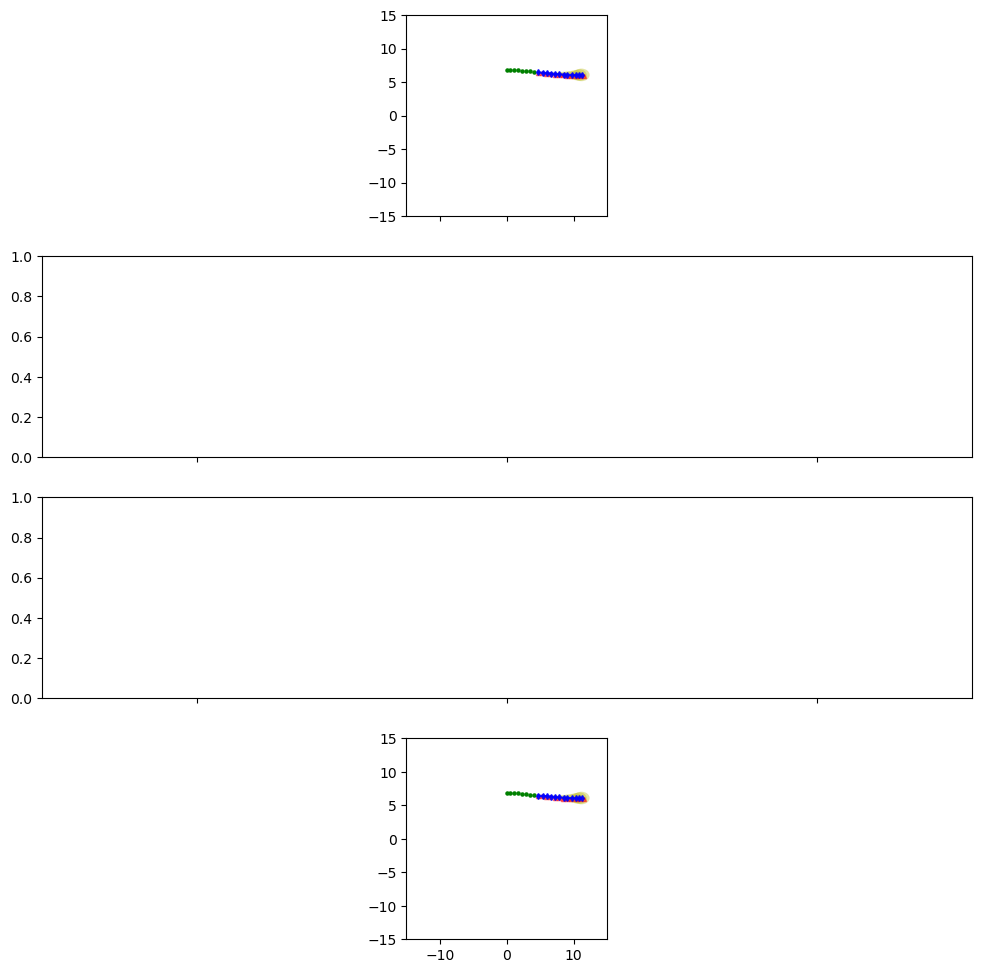

In [35]:
id_list = [36]

for id_no in id_list:
    plot_UQ (test_input[:,0,:,:].detach().cpu().numpy(),
            test_output[:,0,:,:].detach().cpu().numpy(), 
            mu_preds.detach().cpu().numpy(), 
            sigma_preds.detach().cpu().numpy(), 
            gaussian_test_traj.detach().cpu().numpy(),
            test_start_pos.squeeze(),
            id_no = id_no)

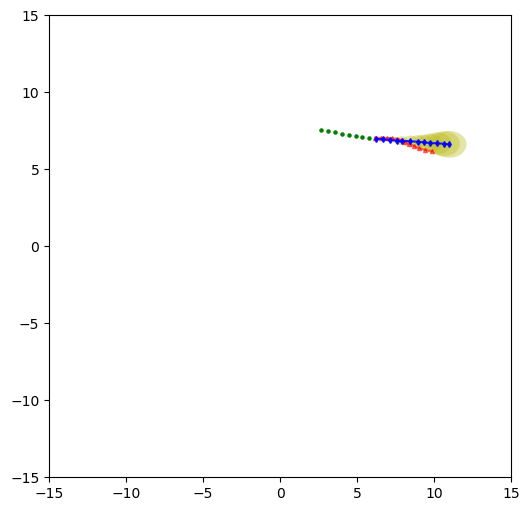

In [36]:
## Animate the Trajectory for visualizing UQ:
import matplotlib.animation as animation

def animate_UQ(X_test, y_test, mus, sigmas, ground_cov, initial_pos, id_list):
    num_fea = mus.shape[3]
    mu_preds = mus
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define the initialization function to clear the plot
    def init():
        ax.clear()
        ax.set_xlim([-15, 15])
        ax.set_ylim([-15, 15])
        ax.set_aspect('equal', adjustable='box')
        return ax,
    
    # Define the animation function
    def animate(id_no):
        ax.clear()
        ax.set_xlim([-15, 15])
        ax.set_ylim([-15, 15])
        ax.set_aspect('equal', adjustable='box')

        ax.scatter(X_test[id_no, :, 0] + initial_pos[id_no,0], X_test[id_no, :, 1] + initial_pos[id_no,1], color='g', marker='o', s=5, label='Input')
        ax.plot(y_test[id_no, :, 0] + initial_pos[id_no,0], y_test[id_no, :, 1] + initial_pos[id_no,1], color='r', alpha=0.5, marker='^', ms=3, label='Ground Truth')
        
        mu_ens = weighted_sum(weights, mu_preds)
        ax.plot(mu_ens[id_no, :, 0] + initial_pos[id_no,0], mu_ens[id_no, :, 1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms=3, label='NN state Estimate')

        var_aleatoric = weighted_sum(weights, sigmas[:, :, :, :2])
        var_epistemic = weighted_sum(weights, mu_preds[:, :, :, :2] ** 2) - mu_ens[:, :, :2] ** 2
        var_ens = var_aleatoric + var_epistemic
        var_state_unc = weighted_sum(weights, mu_preds[:, :, :, 2:4])
        
        for pred in range(pred_len):
            mean = np.squeeze(mu_ens[id_no, pred, :2]  + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no, pred, :])))
            cov_state = np.squeeze(var_state_unc[id_no, pred, :2])
            cov_state = np.diag(np.squeeze(cov_state))
            
            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)
            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)
            
            for j in range(1, 2):
                ell1 = Ellipse(xy=(mean[0], mean[1]),
                               width=(1 * lambda_ale[0]) * j * 2,
                               height=(1 * lambda_ale[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', lw=0.5)
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2 / j)
                ax.add_artist(ell1)

                ell2 = Ellipse(xy=(mean[0], mean[1]),
                               width=(lambda_tot[0]) * j * 2,
                               height=(lambda_tot[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', linestyle='--', lw=0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4 / j)
                ax.add_artist(ell2)

        # ax.legend()
        return ax,

    ani = animation.FuncAnimation(fig, animate, frames=id_list, init_func=init, blit=False, repeat=False)
    anim_writer = animation.PillowWriter(fps=2)
    ani.save('Trajectory_trajnet.gif', writer=anim_writer)
    plt.show()

# Example usage
id_list = list(range(10,100))  # Add more IDs as needed
animate_UQ(test_input[:, 0, :, :].detach().cpu().numpy(),
           test_output[:, 0, :, :].detach().cpu().numpy(),
           mu_preds.detach().cpu().numpy(),
           sigma_preds.detach().cpu().numpy(),
           gaussian_test_traj.detach().cpu().numpy(),
           test_start_pos.squeeze(),
           id_list)

In [37]:
test_output = torch.squeeze(test_output)

In [38]:
test_output.shape

torch.Size([5910, 12, 4])

In [39]:
from utils import *

# Compute the average Displacement and final displacement error:
ADE = average_displacement_error(pred_len, mu_preds, torch.tensor(test_output).float().to(device).unsqueeze(0))
FDE = final_displacement_error(pred_len, mu_preds, torch.tensor(test_output).float().to(device).unsqueeze(0))

/tmp/ipykernel_329279/526604691.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ADE = average_displacement_error(pred_len, mu_preds, torch.tensor(test_output).float().to(device).unsqueeze(0))
/tmp/ipykernel_329279/526604691.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  FDE = final_displacement_error(pred_len, mu_preds, torch.tensor(test_output).float().to(device).unsqueeze(0))


In [40]:
ADE

tensor([0.3837])

In [41]:
FDE

tensor([0.8016])

In [183]:
test_input.shape

torch.Size([2356, 1, 8, 4])